# 🚀 Snorkel Intro Tutorial: Data Labeling

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying YouTube comments as spam or not spam.
The goal of this tutorial is to illustrate the basic components and concepts of Snorkel in a simple way, but also to dive into the actual process of iteratively developing real applications in Snorkel.

**Note that this is a toy dataset that helps highlight the different features of Snorkel. For examples of high-performance, real-world uses of Snorkel, see [our publications list](https://www.snorkel.org/resources/).**

Additionally:
* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)

Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not spam.
We have access to a large amount of *unlabeled data* in the form of YouTube comments with some metadata.
In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.
We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example,
we can write an LF that labels data points with `"http"` in the comment text as spam since many spam
comments contain links:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/), originally introduced in ["TubeSpam: Comment Spam Filtering on YouTube"](https://ieeexplore.ieee.org/document/7424299/), ICMLA'15 (T.C. Alberto, J.V. Lochter, J.V. Almeida).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a novel, theoretically-grounded [modeling approach](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`HAM`**: comments relevant to the video (even very simple ones), or
* **`SPAM`**: irrelevant (often trying to advertise something) or inappropriate messages

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

### Data Splits in Snorkel

We split our data into two sets:
* **Training Set**: The largest split of the dataset, and the one without any ground truth ("gold") labels.
We will generate labels for these data points with weak supervision.
* **Test Set**: A small, standard held-out blind hand-labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.

Note that in more advanced production settings, we will often further split up the available hand-labeled data into a _development split_, for getting ideas to write labeling functions, and a _validation split_ for e.g. checking our performance without looking at test set scores, hyperparameter tuning, etc.  These splits are used in some of the other advanced tutorials, but omitted for simplicity here.

## 1. Loading Data

We load the YouTube comments dataset and create Pandas DataFrame objects for the train and test sets.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html).

Each DataFrame consists of the following fields:
* **`author`**: Username of the comment author
* **`data`**: Date and time the comment was posted
* **`text`**: Raw text content of the comment
* **`label`**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **`video`**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into DataFrames, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The fifth video is part of the `test` set.

This next cell takes care of some notebook-specific housekeeping.
You can ignore it.

In [1]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

If you want to display all comment text untruncated, change `DISPLAY_ALL_TEXT` to `True` below.

In [2]:
import pandas as pd


DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

This next cell makes sure a spaCy English model is downloaded.
If this is your first time downloading this model, restart the kernel after executing the next cell.

In [3]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

You should consider upgrading via the '/home/zjmiao/Documents/snorkel-tutorials/.envsnorkel/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
from utils import load_spam_dataset

df_train, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

The class distribution varies slightly between `SPAM` and `HAM`, but they're approximately class-balanced.

In [5]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

## 2. Writing Labeling Functions (LFs)

### A gentle introduction to LFs

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `HAM` or `SPAM`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.
Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point). This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on data points in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen data points.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

### a) Exploring the training set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [6]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


One dominant pattern in the comments that look like spam (which we might know from prior domain experience, or from inspection of a few training data points) is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

### b) Writing an LF to identify spammy comments that use the phrase "check out"

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.

Let's start developing an LF to catch instances of commenters trying to get people to "check out" their channel, video, or website.
We'll start by just looking for the exact string `"check out"` in the text, and see how that compares to looking for just `"check"` in the text.
For the two versions of our rule, we'll write a Python function over a single data point that express it, then add the decorator.

In [7]:
from snorkel.labeling import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create a label matrix for the `train` set.

In [8]:
from snorkel.labeling import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 38138.12it/s]


In [9]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

### c) Evaluate performance on training set

We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [10]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%


Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
**Note that in our current setup, we can't compute these statistics because we don't have any ground-truth labels (other than in the test set, which we cannot look at). Not to worry—Snorkel's `LabelModel` will estimate them without needing any ground-truth labels in the next step!**

In [11]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


We might want to pick the `check` rule, since `check` has higher coverage. Let's take a look at 10 random `train` set data points where `check` labeled `SPAM` to see if it matches our intuition or if we can identify some false positives.

In [12]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


No clear false positives here, but many look like they could be labeled by `check_out` as well.

Let's see 10 data points where `check_out` abstained, but `check` labeled. We can use the`get_label_buckets(...)` to group data points by their predicted label and/or true labels.

In [13]:
from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


Most of these seem like small modifications of "check out", like "check me out" or "check it out".
Can we get the best of both worlds?

### d) Balance accuracy and coverage

Let's see if we can use regular expressions to account for modifications of "check out" and get the coverage of `check` plus the accuracy of `check_out`.

In [14]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [15]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 27539.04it/s]


In [16]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


We've split the difference in `train` set coverage—this looks promising!
Let's verify that we corrected our false positive from before.

To understand the coverage difference between `check` and `regex_check_out`, let's take a look at 10 data points from the `train` set.
Remember: coverage isn't always good.
Adding false positives will increase coverage.

In [17]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


Most of these are SPAM, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

### e) Writing an LF that uses a third-party model

The LF interface is extremely flexible, and can wrap existing models.
A common technique is to use a commodity model trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but we may believe that `SPAM` and `HAM` comments have different distributions of sentiment scores.
We'll focus on writing LFs for `HAM`, since we identified `SPAM` comments above.

**A brief intro to `Preprocessor`s**

A [Snorkel `Preprocessor`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.Preprocessor.html#snorkel.preprocess.Preprocessor)
is constructed from a black-box Python function that maps a data point to a new data point.
`LabelingFunction`s can use `Preprocessor`s, which lets us write LFs over transformed or enhanced data points.
We add the [`@preprocessor(...)` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html)
to preprocessing functions to create `Preprocessor`s.
`Preprocessor`s also have extra functionality, such as memoization
(i.e. input/output caching, so it doesn't re-execute for each LF that uses it).

We'll start by creating a `Preprocessor` that runs `TextBlob` on our comments, then extracts the polarity and subjectivity scores.

In [18]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

We can now pick a reasonable threshold and write a corresponding labeling function (note that it doesn't have to be perfect as the `LabelModel` will soon help us estimate each labeling function's accuracy and reweight their outputs accordingly):

In [19]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

Let's do the same for the subjectivity scores.
This will run faster than the last cell, since we memoized the `Preprocessor` outputs.

In [20]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

Let's apply our LFs so we can analyze their performance.

In [21]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 1586/1586 [00:01<00:00, 1423.85it/s]


In [22]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


**Again, these LFs aren't perfect—note that the `textblob_subjectivity` LF has fairly high coverage and could have a high rate of false positives. We'll rely on Snorkel's `LabelModel` to estimate the labeling function accuracies and reweight and combine their outputs accordingly.**

## 3. Writing More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all.
We could just use that single simple heuristic to complete the task.
But most problems are not that simple.
Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that no LF voted on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following sections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### a) Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.
These will often follow the same execution pattern, so we can create a template and use the `resources` parameter to pass in LF-specific keywords.
Similar to the [`labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html#snorkel.labeling.labeling_function),
the [`LabelingFunction` class](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction)
wraps a Python function (the `f` parameter), and we can use the `resources` parameter to pass in keyword arguments (here, our keywords to lookup) to said function.

In [23]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

### b) Pattern-matching LFs (regular expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.
The LF we developed above (`regex_check_out`) is an example of this.

### c)  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [24]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

### d) LFs with Complex Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it.
We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessor`s.

For example, we can use the fantastic NLP (natural language processing) tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.
Snorkel provides a prebuilt preprocessor for spaCy called `SpacyPreprocessor` which adds a new field to the
data point containing a [spaCy `Doc` object](https://spacy.io/api/doc).
For more info, see the [`SpacyPreprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor).


If you prefer to use a different NLP tool, you can also wrap that as a `Preprocessor` and use it in the same way.
For more info, see the [`preprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html#snorkel.preprocess.preprocessor).

If the spaCy English model wasn't already installed, the next cell may raise an exception.
If this happens, restart the kernel and re-execute the cells up to this point.

In [25]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [26]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP applications, we also provide a
[prebuilt `labeling_function`-like decorator that uses spaCy](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.lf.nlp.nlp_labeling_function.html#snorkel.labeling.lf.nlp.nlp_labeling_function).
This resulting LF is identical to the one defined manually above.

In [27]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

**Adding new domain-specific preprocessors and LF types is a great way to contribute to Snorkel!
If you have an idea, feel free to reach out to the maintainers or submit a PR!**

### e) Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.
The TextBlob-based LFs we created above are great examples of this!

## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
One of the key goals of Snorkel is _not_ to replace the effort, creativity, and subject matter expertise required to come up with these labeling functions, but rather to make it faster to write them, since **in Snorkel the labeling functions are assumed to be noisy, i.e. innaccurate, overlapping, etc.**
Said another way: the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [28]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get the label matrices.
The Pandas format provides an easy interface that many practitioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [29]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:01<00:00, 152.52it/s]


In [30]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.185372,0.109710
keyword_subscribe,1,[1],0.127364,0.108449,0.068726
keyword_http,2,[1],0.119168,0.100252,0.080706
keyword_please,3,[1],0.112232,0.109710,0.056747
keyword_song,4,[0],0.141866,0.109710,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.087011
short_comment,6,[0],0.225725,0.145019,0.074401
has_person_nlp,7,[0],0.071879,0.056747,0.030895
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.252837,0.160151


We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well.
We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

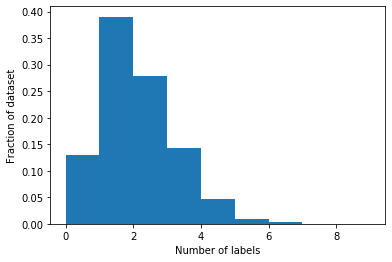

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs.
Fortunately, the labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.baselines.MajorityLabelVoter.html#snorkel.labeling.model.baselines.MajorityLabelVoter).

In [32]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [33]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

However, as we can see from the summary statistics of our LFs in the previous section, they have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [34]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

/home/zjmiao/Documents/snorkel-tutorials/.envsnorkel/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time.
However, these models (i.e. these re-weighted combinations of our labeling function's votes) will abstain on the data points that our labeling functions don't cover (and additionally, may require slow or unavailable features to execute at test time).
In the next section, we will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier **which can generalize beyond the labeling function outputs** to see if we can improve performance further.
This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments.
For more information on the properties of the label model, see the [Snorkel documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

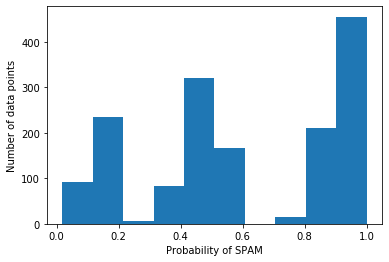

In [35]:


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [36]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [37]:
probs_train_filtered

array([[6.57678162e-01, 3.42321838e-01],
       [4.58454017e-06, 9.99995415e-01],
       [8.94210101e-01, 1.05789899e-01],
       ...,
       [4.65886684e-07, 9.99999534e-01],
       [2.22374736e-03, 9.97776253e-01],
       [1.23528905e-08, 9.99999988e-01]])

## Explaining a labelling prediction using Anchor


In [38]:
# refer to section 4, combine multiple labelling functions
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


# df_train, df_test = load_spam_dataset()
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train_filtered)
L_test = applier.apply(df=df_test)



100%|██████████| 250/250 [00:00<00:00, 6327.32it/s]


In [39]:
print(L_train)

[[-1 -1  1 ... -1 -1 -1]
 [-1  1 -1 ... -1 -1  0]
 [-1 -1  1 ... -1 -1 -1]
 ...
 [ 1  1 -1 ... -1 -1  0]
 [-1  1 -1 ... -1 -1  0]
 [ 1 -1 -1 ... -1 -1 -1]]


In [40]:
df_train_filtered = df_train_filtered.reset_index(drop=True)
print(df_train_filtered)

                                    author                        date  \
0                         Alessandro leite         2014-11-05T22:21:36   
1                             Salim Tayara         2014-11-02T14:33:30   
2                             Giang Nguyen         2014-11-06T04:55:41   
3                            Praise Samuel         2014-11-08T11:10:30   
4                            Malin Linford         2014-11-05T01:13:43   
5                              Lone Twistt         2013-11-28T17:34:55   
6                                Олег Пась         2014-11-03T23:29:00   
7                                  JD COKE         2014-11-08T02:24:02   
8                             zhichao wang         2013-11-29T02:13:56   
9                             Rancy Gaming         2014-11-06T09:41:07   
10                Bishwaroop Bhattacharjee         2014-11-08T12:34:11   
11                               Tedi Foto         2014-11-08T09:33:30   
12                                 Tee

In [41]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


# df_train, df_test = load_spam_dataset()
applier = PandasLFApplier(lfs=lfs)
# L_train = applier.apply(df=df_train)
# L_test = applier.apply(df=df_test)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [42]:
# has to re-define the prediction function
def predict_lr_with_idx(idx):
    df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
#     df_tmp.at[1558, 'text'] = texts[0]
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

#         df_tmp.at[idx, 'text'] = texts[0]
        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf)
#         print(texts, L_tmp)
        res = label_model.predict(L=L_tmp)
        res_type = []
        for x in res:
            res_type.append(type(x))
#         print(res, type(res), res_type)
#         if res[0] == -1:
#             res[0] = 0
        return res
    
    return predict_lr

In [43]:
def predict_majority_lr_with_idx(idx):
    
    df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)
        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf)
        return majority_model.predict(L=L_tmp)
    return predict_lr

In [44]:
from anchor import anchor_text
import spacy
import numpy as np

In [45]:
nlp1 = spacy.load('en_core_web_lg')
# explainer = anchor_text.AnchorText(nlp1, [ABSTAIN,HAM, SPAM], use_unk_distribution=True)



In [46]:
explainer = anchor_text.AnchorText(nlp1, [HAM, SPAM], use_unk_distribution=True)

In [47]:
# majority_model.predict(L=np.asarray([[0,-1,1]]))

In [48]:
np.random.seed(3)
# text = ' '.join(['Check out my channel for funny skits! Thanks! '])
text = 'subscribe to my channel  /watch?v=NxK32i0HkDs'
# pred = explainer.class_names[predict_lr([text])[0]]
# alternative =  explainer.class_names[1 - predict_lr([text])[0]]
pred = predict_lr_with_idx(1356)([text])[0]
alternative =  1 - predict_lr_with_idx(1356)([text])[0]
print('Prediction: %s' % pred)


100%|██████████| 1/1 [00:00<00:00, 837.19it/s]

Prediction: 1


In [49]:
# mv_pred = predict_majority_lr_with_idx(1560)([text])[0]
# print('Prediction: %s' % mv_pred)


In [50]:
exp = explainer.explain_instance(text, predict_lr_with_idx(1356), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 247.54it/s]


In [51]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: my
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK UNK my channel   /watch?v UNK UNK
subscribe to my channel UNK /watch?v UNK UNK
subscribe to my channel UNK /watch?v = UNK
UNK to my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my UNK UNK /watch?v = NxK32i0HkDs
subscribe to my UNK UNK /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK UNK my channel   /watch?v UNK NxK32i0HkDs
subscribe UNK my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my channel UNK UNK UNK UNK

Examples where anchor applies and model predicts 0:




In [52]:
print('\n'.join([x[0] for x in exp.examples(only_different_prediction=True)]))
print('===============================')
print('\n'.join([x[0] for x in exp.examples()]))
print('===============================')
print('\n'.join([x[0] for x in exp.examples(partial_index=0)]))
# print('================= Print all examples =============')
for x in exp.examples():
    pred = predict_lr_with_idx(1356)(x)
    print(x, pred)


100%|██████████| 1/1 [00:00<00:00, 912.20it/s]


UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my channel   /watch?v UNK UNK
subscribe UNK my UNK   /watch?v UNK UNK
UNK to my channel   UNK = UNK
UNK to my channel   /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK to my UNK UNK UNK = UNK
UNK UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my channel   /watch?v UNK UNK
subscribe UNK my UNK   /watch?v UNK UNK
UNK to my channel   UNK = UNK
UNK to my channel   /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK to my UNK UNK UNK = UNK
UNK UNK my UNK   UNK = NxK32i0HkDs
['UNK to my channel UNK UNK UNK NxK32i0HkDs'] [1]
['UNK UNK my UNK   UNK UNK NxK32i0HkDs'] [1]
['subscribe UNK my channel   /watch?v UNK UNK'] [1]
['subscribe UNK my UNK   /watch?v UNK UNK'] [1]
['UNK to my channel   UNK = UNK'] [1]
['

In [53]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Partial anchor: my
Precision: 1.00

Examples where anchor applies and model predicts [1]:

UNK UNK my channel   /watch?v UNK UNK
subscribe to my channel UNK /watch?v UNK UNK
subscribe to my channel UNK /watch?v = UNK
UNK to my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my UNK UNK /watch?v = NxK32i0HkDs
subscribe to my UNK UNK /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK UNK my channel   /watch?v UNK NxK32i0HkDs
subscribe UNK my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my channel UNK UNK UNK UNK

Examples where anchor applies and model predicts 0:




In [54]:
pred = predict_lr_with_idx(1356)(["UNK to my UNK   UNK UNK NxK32i0HkDs"])[0]
print(pred)

100%|██████████| 1/1 [00:00<00:00, 951.52it/s]

1


In [55]:
# Another example
# df_train, df_test = load_spam_dataset()
df_train_filtered = df_train_filtered.reset_index(drop=True)

df_tmp = df_train_filtered[1364:1365]
df_tmp.reset_index(drop=True)
print(df_tmp)
print(df_tmp.at[1364,'text'])
print(applier.apply(df=df_tmp))
# print(predict_lr_with_idx(1364)(df_tmp.at[1364,'text']))

100%|██████████| 1/1 [00:00<00:00, 909.24it/s]

            author date                                    text  label  video
1364  Wild 'N' Out  NaN  CHECK OUT Eminem - Rap God LYRIC VIDEO   -1.0      4
CHECK OUT Eminem - Rap God LYRIC VIDEO
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]]


In [56]:
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO"
exp = explainer.explain_instance(text2, predict_lr_with_idx(1364), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 4175.10it/s]


In [57]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: LYRIC AND CHECK AND OUT
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT Eminem UNK Rap God LYRIC UNK
CHECK OUT UNK - Rap God LYRIC VIDEO
CHECK OUT UNK UNK Rap UNK LYRIC UNK
CHECK OUT Eminem - UNK UNK LYRIC VIDEO
CHECK OUT Eminem - UNK God LYRIC UNK
CHECK OUT Eminem UNK UNK God LYRIC UNK
CHECK OUT UNK UNK Rap UNK LYRIC VIDEO
CHECK OUT Eminem UNK Rap God LYRIC VIDEO
CHECK OUT UNK - UNK UNK LYRIC VIDEO
CHECK OUT Eminem - Rap UNK LYRIC UNK

Examples where anchor applies and model predicts 0:

CHECK UNK Eminem - Rap God LYRIC UNK
UNK OUT Eminem UNK Rap God LYRIC VIDEO
CHECK UNK Eminem - UNK God LYRIC UNK
UNK UNK Eminem - Rap God LYRIC VIDEO
CHECK UNK Eminem - UNK God LYRIC VIDEO
UNK OUT Eminem UNK Rap God LYRIC VIDEO
UNK OUT Eminem UNK Rap God LYRIC UNK
UNK UNK Eminem - UNK God LYRIC VIDEO
UNK UNK Eminem - UNK God LYRIC UNK
UNK UNK Eminem - Rap God LYRIC VIDEO


In [58]:
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO LF1:SPAM LF2:HAM LF3:SPAM"
exp = explainer.explain_instance(text2, predict_lr_with_idx(1364), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 520.64it/s]


## Explaining Snorkel Prediction by Perturbing Labelling Functions

In [59]:
import numpy as np
import os
from anchor import utils
from anchor import anchor_tabular
import sklearn
import sklearn.ensemble


In [60]:
# 1. labelling function results as attributes

In [61]:
# df_train, df_test = load_spam_dataset()
df_train_filtered = df_train_filtered.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train_filtered)
L_test = applier.apply(df=df_test)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 250/250 [00:00<00:00, 6365.85it/s]


In [62]:
dataset_folder = '/home/zjmiao/Documents/labelling_explanation/data/'


In [63]:
text_id = np.array(df_train_filtered.index)
text_id = np.reshape(text_id, (-1, 1))

In [64]:
lm_pred = label_model.predict(L_train)

In [65]:
lm_pred = np.reshape(lm_pred, (-1, 1))

In [66]:
lm_pred_test = label_model.predict(L_test)

In [67]:
lm_pred_test

array([ 1,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1,  0,  1,  0,  1,
        1,  0,  1,  0,  1,  1,  0,  0,  1,  0, -1,  0, -1,  1,  1,  0,  1,
        0,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1, -1,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  1,  0,  0,  1,  0,  0,  1, -1,  1,  0,  0,  1,
        1,  1,  1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  1,  0,  0,  0,
        1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  1,
        1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
       -1,  1,  1, -1,  0,  0,  0,  1,  0, -1,  0,  0,  1,  0,  0, -1,  1,
        1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0,
        1,  1,  1, -1, -1,  0, -1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,
       -1,  0,  1,  0,  0,  0,  1,  1,  0,  1,  1,  1,  1,  0, -1,  1,  1,
        1,  1,  1,  0,  1,  0, -1,  0,  1,  0,  0,  1,  0, -1,  0,  1,  0,
        1,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1,  0,  1,  0,  0,  0,  0,
        1,  0,  0,  1,  0

In [68]:
lm_data = np.concatenate((text_id, L_train, lm_pred), axis=1)

In [69]:
np.savetxt(dataset_folder+'spam.tmp.csv', lm_data, fmt='%d', delimiter=",")


In [70]:
features_to_use = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
feature_names = ["text_id", "0:keyword_my", "1:keyword_subscribe",
    "2:keyword_link",
    "3:keyword_please",
    "4:keyword_song",
    "5:regex_check_out",
    "6:short_comment",
    "7:has_person_nlp",
    "8:textblob_polarity",
    "9:textblob_subjectivity", "Snorkel_prediction"]
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'spam.tmp.csv'),
            11, ',', feature_names=feature_names,
            features_to_use=features_to_use,
            feature_transformations=None, fill_na='-999',
            categorical_features=categorical_features, discretize=False,
            filter_fn=None)
# dataset.class_names = ['HAM', 'SPAM']

In [71]:
print(dataset.class_names)
print(dataset.feature_names)
print(dataset.labels_test)
print(dataset.labels_train)
print(dataset.categorical_names)

[b'0', b'1']
['text_id', '0:keyword_my', '1:keyword_subscribe', '2:keyword_link', '3:keyword_please', '4:keyword_song', '5:regex_check_out', '6:short_comment', '7:has_person_nlp', '8:textblob_polarity', '9:textblob_subjectivity']
[1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
[0 0 1 ... 0 0 1]
{1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '1'], 4: ['-1', '1'], 5: ['-1', '0'], 6: ['-1', '1'], 7: ['-1', '0'], 8: ['-1', '0'], 9: ['-1', '0'], 10: ['-1', '0']}


In [72]:
dataset.train


array([[4.430e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [9.000e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.131e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.096e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.350e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.061e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [73]:
lm_data

array([[   0,   -1,   -1, ...,   -1,   -1,    0],
       [   1,   -1,    1, ...,   -1,    0,    1],
       [   2,   -1,   -1, ...,   -1,   -1,    0],
       ...,
       [1377,    1,    1, ...,   -1,    0,    1],
       [1378,   -1,    1, ...,   -1,    0,    1],
       [1379,    1,   -1, ...,   -1,   -1,    1]])

In [74]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 1.0
Test 0.9855072463768116


In [75]:
from sklearn.linear_model import LinearRegression
lc = LinearRegression().fit(dataset.train, dataset.labels_train)
# print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, lc.predict(dataset.train)))
# print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, lc.predict(dataset.test)))
print(lc.score(dataset.train, dataset.labels_train))
print(lc.score(dataset.test, dataset.labels_test))

0.6680889045544347
0.6702629862582002


In [76]:
tab_explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)

In [77]:
dataset.categorical_names

{1: ['-1', '1'],
 2: ['-1', '1'],
 3: ['-1', '1'],
 4: ['-1', '1'],
 5: ['-1', '0'],
 6: ['-1', '1'],
 7: ['-1', '0'],
 8: ['-1', '0'],
 9: ['-1', '0'],
 10: ['-1', '0']}

In [78]:
exp_ins = dataset.train[np.where(dataset.train[:,0] == 1364)][0]
print(exp_ins)

[1.364e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00]


In [79]:
# exp_ins = dataset.test[np.where(dataset.test[:,0] == 1569)][0]
# print(exp_ins)
# #1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '1'], 4: ['-1', '1'], 5: ['-1', '0'], 
# #6: ['-1', '1'], 7: ['-1', '0'], 8: ['-1', '0'], 9: ['-1', '0'], 10: ['-1', '0']}

In [80]:
# dataset.test[np.where((dataset.test[:,1] == 0) * (dataset.test[:,2] == 0) * (dataset.test[:,6] == 1) *
#                       (dataset.test[:,7] == 0) * (dataset.test[:,8] == 1) * (dataset.test[:,9] == 0) * 
#                       (dataset.test[:,10] == 1))]

In [81]:
lm_data[np.where(lm_data[:,0] == 1364)][0]

array([1364,   -1,   -1,   -1,   -1,   -1,    1,   -1,    0,   -1,    0,
          1])

In [82]:
df_train_filtered[1364:1365]
# 1569,-1,-1,-1,-1,-1,1,-1,0,-1,0,1


,author,date,text,label,video
1364,Wild 'N' Out,NaN,CHECK OUT Eminem - Rap God LYRIC VIDEO,-1.0,4


In [83]:
applier.apply(df=df_train_filtered[1364:1365])

100%|██████████| 1/1 [00:00<00:00, 475.87it/s]


array([[-1, -1, -1, -1, -1,  1, -1,  0, -1,  0]])

In [84]:
exp_ins.reshape(1, -1)
c.predict(exp_ins.reshape(1, -1))[0]

1

In [85]:
# exp_ins.reshape(1, -1).tolist()
exp_ins.reshape(1, -1)[:, [i  for i in range(1, 11)]].astype(int)


array([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])

In [86]:
np.random.seed(1)
print('Prediction: ', tab_explainer.class_names[c.predict(exp_ins.reshape(1, -1))[0]])
exp = tab_explainer.explain_instance(exp_ins, c.predict, threshold=0.9)

Prediction:  b'1'


In [87]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: 5:regex_check_out = 1 AND 6:short_comment = -1
Precision: 1.00
Coverage: 0.27


In [88]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print('Precision: %.2f' % exp.coverage(0))
print()

Partial anchor: 5:regex_check_out = 1
Precision: 0.79
Precision: 0.27



In [89]:
# has to re-define the prediction function
def predict_lr_tabular(row):
    print(row.shape)
    d = row[:, [i  for i in range(1, 11)]].astype(int)
#     dataset.categorical_names
    print(d.shape)

    L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(dataset.categorical_names[y[0]+1][y[1]]), 
                                              enumerate(x.tolist()))), 1, d)
    
# def array_map(x):
#     return np.array(list(map(f, x)))
    
    res = label_model.predict(L=L_tmp)
    print(L_tmp, res)
    return res
    


In [90]:
np.random.seed(1)
print('Prediction: ', tab_explainer.class_names[predict_lr_tabular(exp_ins.reshape(1, -1))[0]])
exp = tab_explainer.explain_instance(exp_ins, predict_lr_tabular, threshold=0.95)

(1, 11)
(1, 10)
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]] [1]
Prediction:  b'1'
(1, 11)
(1, 10)
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]] [1]
(1, 11)
(1, 10)
[[ 1 -1 -1 -1 -1  1 -1 -1 -1  0]] [1]
(100, 11)
(100, 10)
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1  0]
 [-1 -1 -1 -1  0 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1  0]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1 -1  0  0 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0 -1  0 -1 -1  0]
 [-1 -1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0 -1  0 -1 -1  0]
 [ 1  1 -1  1 -1 -1 -1 -1  0 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 

In [91]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: 5:regex_check_out = 1 AND 6:short_comment = -1
Precision: 0.98
Coverage: 0.27


## Perturbing LF Results and Text at the Same Time

In [103]:
from ModelForTextLabelling import predict_transformers, train_model_for_text_labelling, \
    ModelForTextLabelling, eval_bert_classification

In [104]:
classes = ['HAM', 'SPAM']
lf_vocab = [ABSTAIN, HAM, SPAM]
res2tag = {-1: 'ABSTAIN', 0: 'HAM', 1: 'SPAM'}

In [105]:
texts = list(df_train_filtered.text)
texts_test = list(df_test.text)

In [106]:
texts_test[211]

'SO THEN HOW ARE YOU GOING TO CALL YOURSELF A INSTRUMENTAL SONGWRITER IF THERES NO SINGING THERES NO SONG TO WRITE!?!?! LOL.   YOU GOT ALOT TO LEARN KID BUT HEY DON&#39;T FORGET TO SUBSCRIBE!'

In [107]:
lfrs = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], enumerate(x))), L_train.tolist()))


In [108]:
lfrs[1364]

['LF0:ABSTAIN',
 'LF1:ABSTAIN',
 'LF2:ABSTAIN',
 'LF3:ABSTAIN',
 'LF4:ABSTAIN',
 'LF5:SPAM',
 'LF6:ABSTAIN',
 'LF7:HAM',
 'LF8:ABSTAIN',
 'LF9:HAM']

In [109]:
lfrs_test = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], 
                                        enumerate(x))), 
                     L_test.tolist()))

In [110]:
for idx in range(len(lfrs_test)):
    if 10 <= len(texts_test[idx].split(' ')) and len(texts_test[idx].split(' ')) <= 30:
        cnt = 0 
        for j in range(10):
            if 'ABSTAIN' in lfrs_test[idx][j]:
                cnt += 1
        if cnt <= 8:
            print('=========================')
            print(texts_test[idx])
            print(df_test[idx:idx+1].label)
            print(lfrs_test[idx])

Subscribe my channel  I RECORDING FIFA 15 GOALS WATCH NOW :D﻿
2    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN']
SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakira GuruOfMovie﻿
4    1
Name: label, dtype: int64
['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']
Subscribe to my Youtube Channel!! :) Suscribite a mi canal de Youtube -WhatUKnow
9    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM']
i am from Brazil please subscribe my channel love you all﻿
12    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:SPAM', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']
Oh my god go to 1 billion of replay i lov

In [109]:
print(lfs)

[LabelingFunction keyword_my, Preprocessors: [], LabelingFunction keyword_subscribe, Preprocessors: [], LabelingFunction keyword_http, Preprocessors: [], LabelingFunction keyword_please, Preprocessors: [], LabelingFunction keyword_song, Preprocessors: [], LabelingFunction regex_check_out, Preprocessors: [], LabelingFunction short_comment, Preprocessors: [], NLPLabelingFunction has_person_nlp, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []], LabelingFunction textblob_polarity, Preprocessors: [LambdaMapper textblob_sentiment, Pre: []], LabelingFunction textblob_subjectivity, Preprocessors: [LambdaMapper textblob_sentiment, Pre: []]]


In [110]:
labels_train = list(map(lambda x: res2tag[x], np.reshape(lm_pred, (1, -1)).tolist()[0]))
labels_test = list(map(lambda x: res2tag[x], Y_test.tolist()))

In [111]:
train_dataset = TextLabellingDataset((texts, lfrs, labels_train), classes, tokenizer, max_len=512)
test_dataset = TextLabellingDataset((texts_test, lfrs_test, labels_test), classes, tokenizer, max_len=512)

NameError: name 'TextLabellingDataset' is not defined

In [ ]:
train_dataset.idx2tag

In [196]:
train_dataset[1364]

NameError: name 'train_dataset' is not defined

## Train BERT model for labelling on text+ LF results

In [ ]:
bert_model, tokenizer = ModelForTextLabelling(model_type='distilbert', 
                                              num_labels=2, model_path='best_test.pt', 
                                              lfs=lfs, lf_vocab=lf_vocab, res2tag=res2tag)

In [ ]:
tokenizer.tokenize('[CLS] Nimam [SEP] LF1:HAM LF2:ABSTAIN [SEP]')

In [120]:

lfr = ['LF0:ABSTAIN',
 'LF1:ABSTAIN',
 'LF2:ABSTAIN',
 'LF3:ABSTAIN',
 'LF4:ABSTAIN',
 'LF5:SPAM',
 'LF6:ABSTAIN',
 'LF7:HAM',
 'LF8:ABSTAIN',
 'LF9:HAM']
# labels_list = list(map(lambda x: res2tag[x], [0 for i in range(len(texts))]))
labels = ['HAM']


predict_transformers(['great song, but we all know that Katy buys her views..﻿,'], [lfr], labels)

[0]


[0]

In [123]:
print(eval_bert_classification(train_dataset))

accuracy=0.884
precision=0.856
recall=0.907
f1=0.881
(0.884, 0.856, 0.9067796610169492, 0.8806584362139918, tensor(0.2574))


In [124]:
print(eval_bert_classification(test_dataset))

accuracy=0.900
precision=0.878
recall=0.915
f1=0.896
(0.9, 0.8780487804878049, 0.9152542372881356, 0.896265560165975, tensor(0.3128))


In [243]:
def predict_lr_with_idx_transformers(idx):
    if idx < 0:
        idx = -idx - 1
        df_tmp = df_test[idx:idx+1]
    else:
        df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    
    def predict_lr(texts):
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf).tolist()
#         lfrs = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], 
#                                         enumerate(x))), 
#                      L_tmp.tolist()))
#         print(texts, L_tmp)

        text_list = list(map(lambda x: ' '.join(x.split(' ')[:-10]), texts))
        lfrs = list(map(lambda x: x.split(' ')[-10:], texts))
        for i in range(len(texts)):
            for j in range(len(L_tmp[0])):
                if lfrs[i][j] != 'UNK':
                    y = L_tmp[i][j]
                    lfrs[i][j] = 'LF' + str(j) + ':' + res2tag[y]

#         res = predict_bert(texts, lfrs, [res2tag[int(df_tmp.label.tolist()[0])] for i in range(len(texts))])
        res = predict_transformers(texts, lfrs, ['HAM' for i in range(len(texts))])
        print(text_list, lfrs)
        print(res)
        return res
    
    return predict_lr



In [150]:
df_train_filtered[1364:1364+1].label.tolist()

[-1.0]

In [92]:
# 
def predict_lr_with_idx_text_and_lfs(idx):
    if idx < 0:
        idx = -idx-1
        df_tmp = df_test[idx:idx+1]
    else:
        df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
#     df_tmp.at[1558, 'text'] = texts[0]
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)
        text_list = list(map(lambda x: ' '.join(x.split(' ')[:-10]), texts))
        
        for i in range(len(texts)):
            newdf.at[i, 'text'] = text_list[i]
        L_tmp = applier.apply(df=newdf)
        lfrs = list(map(lambda x: x.split(' ')[-10:], texts))
#         print(text_list)
#         print(L_tmp, lfrs)
        for i in range(len(texts)):
#             print(text_list[i], lfrs[i])
            for j in range(len(L_tmp[0])):
                if lfrs[i][j] == 'UNK':
                    # L_tmp[i][j] = ABSTAIN
                    L_tmp[i][j] = int(random.choice(dataset.categorical_names[j+1]))
#                     if L_tmp[i][j] != ABSTAIN:
#                         L_tmp[i][j] = int(random.choice(dataset.categorical_names[j+1]))
                    

        res = label_model.predict(L=L_tmp)
        return res
    
    return predict_lr


In [93]:
import random
random.choice( [1,2,3])

1

In [94]:
dataset.categorical_names

{1: ['-1', '1'],
 2: ['-1', '1'],
 3: ['-1', '1'],
 4: ['-1', '1'],
 5: ['-1', '0'],
 6: ['-1', '1'],
 7: ['-1', '0'],
 8: ['-1', '0'],
 9: ['-1', '0'],
 10: ['-1', '0']}

In [189]:
def print_expl(exp):
    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print()
    print('Examples where anchor applies and model predicts %s:' % pred)
    print()
    print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
    print()
    print('Examples where anchor applies and model predicts %s:' % alternative)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

    print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
    print('Precision: %.2f' % exp.precision(0))
    print()
    print('Examples where anchor applies and model predicts %s:' % pred)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
    print()
    print('Examples where anchor applies and model predicts %s:' % alternative)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

In [109]:
text3 = "CHECK OUT Eminem - Rap God LYRIC VIDEO " + \
' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN',
          'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM',
          'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'])
exp = explainer.explain_instance(text3, predict_lr_with_idx_text_and_lfs(1364), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 4083.64it/s]


100%|██████████| 10/10 [00:00<00:00, 4160.19it/s]


100%|██████████| 10/10 [00:00<00:00, 4039.20it/s]


100%|██████████| 10/10 [00:00<00:00, 4019.07it/s]


In [110]:
print_expl(exp)

Anchor: LF8:ABSTAIN AND LF6:ABSTAIN AND OUT AND CHECK AND LF5:SPAM
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT UNK - UNK UNK LYRIC UNK LF0:ABSTAIN UNK LF2:ABSTAIN LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN UNK
CHECK OUT Eminem UNK Rap UNK UNK VIDEO UNK LF1:ABSTAIN LF2:ABSTAIN UNK UNK LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN LF9:HAM
CHECK OUT UNK - UNK UNK LYRIC UNK UNK LF1:ABSTAIN UNK UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN UNK
CHECK OUT UNK - Rap UNK UNK VIDEO UNK UNK UNK UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN LF9:HAM
CHECK OUT UNK UNK Rap UNK UNK VIDEO LF0:ABSTAIN LF1:ABSTAIN UNK UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN UNK
CHECK OUT UNK UNK Rap UNK UNK VIDEO LF0:ABSTAIN LF1:ABSTAIN UNK LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAI
CHECK OUT Eminem - UNK God LYRIC UNK LF0:ABSTAIN LF1:ABSTAIN UNK LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN UNK
CHECK OUT UNK UNK Rap God UNK VIDEO UNK

In [113]:
## Example Test 233


In [96]:
# text4 = "I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + \
# ' '.join(['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 
#          'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'])
text4 = "I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + \
' '.join(['LF'+str(i) for i in range(len(lfs))])

exp = explainer.explain_instance(text4, predict_lr_with_idx_text_and_lfs(-126-1), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 158.50it/s]


In [98]:
print_expl(exp)

Anchor: my AND LF0
Precision: 1.00

Examples where anchor applies and model predicts 1:

I love UNK UNK UNK UNK UNK ! This UNK UNK of my fave songs now UNK UNK UNK subscribed :) UNK UNK LF0 LF1 UNK UNK UNK UNK LF6 LF7 UNK
UNK UNK UNK ! UNK ! ! ! UNK UNK one of my UNK songs now UNK UNK just subscribed :) :) :) LF0 LF1 LF2 UNK UNK UNK LF6 LF7 LF8 UNK
I UNK this ! UNK ! UNK ! UNK is one UNK my fave songs now and I UNK UNK UNK :) :) LF0 LF1 LF2 LF3 LF4 UNK UNK LF7 LF8 UNK
I love UNK ! ! UNK ! ! UNK is UNK UNK my UNK songs UNK and UNK UNK subscribed :) UNK UNK LF0 UNK UNK UNK LF4 UNK LF6 UNK LF8 LF9
I UNK this UNK ! ! UNK UNK UNK is one UNK my UNK UNK now and UNK UNK subscribed UNK :) UNK LF0 UNK UNK LF3 UNK UNK LF6 UNK LF8 LF9
I UNK UNK UNK UNK UNK UNK ! UNK is one UNK my fave songs UNK UNK UNK just subscribed :) UNK :) LF0 LF1 UNK UNK LF4 LF5 UNK UNK LF8 L
I UNK this ! ! UNK ! ! UNK is one of my UNK UNK UNK UNK I UNK subscribed UNK :) :) LF0 LF1 LF2 LF3 UNK UNK LF6 UNK UNK UNK
UNK love th

In [270]:
pred = predict_lr_with_idx_text_and_lfs(-126-1)(["I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + 
' '.join(['LF'+str(i) for i in range(len(lfs))])])[0]
print(pred)

100%|██████████| 1/1 [00:00<00:00, 190.83it/s]

['I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :)']
[[ 1  1 -1 -1  0 -1 -1 -1 -1  0]] [['LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7', 'LF8', 'LF9']]
1


In [100]:
exp = explainer.explain_instance(text4, predict_lr_with_idx_text_and_lfs(-126-1), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 153.22it/s]


100%|██████████| 10/10 [00:00<00:00, 154.70it/s]


In [101]:
print_expl(exp)

Anchor: my AND LF0:SPAM
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK UNK UNK ! UNK UNK UNK UNK UNK is one UNK my fave songs now UNK I UNK subscribed :) UNK UNK LF0:SPAM LF1:SPAM UNK LF3:ABSTAIN LF4:HAM LF5:ABSTAIN UNK LF7:ABSTAIN LF8:ABSTAIN LF9:HAM
I UNK UNK ! UNK ! ! ! This is UNK of my fave songs now and I UNK UNK UNK :) UNK LF0:SPAM LF1:SPAM UNK UNK LF4:HAM LF5:ABSTAIN UNK LF7:ABSTAIN UNK LF9:HAM
UNK love UNK ! ! ! UNK UNK This UNK one UNK my UNK songs now UNK I just UNK UNK UNK :) LF0:SPAM UNK UNK UNK LF4:HAM LF5:ABSTAIN UNK LF7:ABSTAIN LF8:ABSTAIN LF9:HAM
I UNK this ! ! ! ! UNK This is one of my UNK songs now UNK UNK just subscribed UNK :) UNK LF0:SPAM LF1:SPAM LF2:ABSTAIN LF3:ABSTAIN UNK UNK UNK LF7:ABSTAIN UNK UNK
I love this UNK ! ! UNK ! UNK is one UNK my fave UNK UNK UNK UNK UNK UNK UNK UNK UNK LF0:SPAM UNK UNK UNK UNK LF5:ABSTAIN LF6:ABSTAIN LF7:ABSTAIN LF8:ABSTAIN LF9:HAM
UNK UNK UNK UNK UNK ! UNK ! This is one UNK my UNK UNK UNK and UNK just U

In [102]:
# text5 = "HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT YOU THINK! " + \
# ' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 
#           'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'])
text5 = "HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT YOU THINK! " + \
' '.join(['LF'+str(i) for i in range(len(lfs))])

exp = explainer.explain_instance(text5, predict_lr_with_idx_text_and_lfs(-225-1), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 190.92it/s]


In [103]:
print_expl(exp)

Anchor: AWESOME AND LF8
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK ! CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK UNK UNK LF0 LF1 LF2 UNK UNK UNK LF6 LF7 LF8
HI UNK CHECK UNK OUR AWESOME COVERS UNK AND UNK WHAT YOU UNK ! UNK UNK UNK LF3 LF4 LF5 UNK UNK L
HI ! UNK UNK OUR AWESOME UNK UNK UNK SAY UNK UNK UNK ! UNK LF1 LF2 UNK UNK LF5 UNK LF7 LF8 LF9
UNK ! CHECK OUT OUR AWESOME COVERS ! AND SAY UNK YOU UNK ! UNK UNK UNK LF3 LF4 UNK LF6 LF7 LF8 U
UNK UNK CHECK OUT UNK AWESOME UNK UNK UNK UNK UNK YOU THINK UNK UNK LF1 UNK UNK UNK UNK LF6 UNK 
UNK ! CHECK UNK UNK AWESOME COVERS ! UNK UNK WHAT YOU THINK UNK UNK UNK UNK LF3 UNK UNK UNK LF7 
UNK UNK UNK OUT UNK AWESOME UNK ! UNK UNK WHAT UNK THINK UNK UNK LF1 UNK LF3 LF4 UNK UNK UNK LF8
HI UNK CHECK UNK UNK AWESOME COVERS ! UNK SAY WHAT YOU THINK UNK LF0 LF1 UNK LF3 LF4 UNK UNK UNK
HI ! CHECK OUT OUR AWESOME COVERS ! AND UNK UNK UNK THINK UNK LF0 UNK LF2 LF3 LF4 LF5 LF6 LF7 LF
HI ! UNK UNK UNK AWESOME COVERS UNK

In [106]:
# text6 = "Facebook is LAME and so 2004! Check out ------------ swagFriends com Make thousands of cool new friends everyday! Join this new movement! " + \
#     ' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 
#               'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'])
text6 = "Facebook is LAME and so 2004! Check out ------------ swagFriends com Make thousands of cool new friends everyday! Join this new movement! " + \
' '.join(['LF'+str(i) for i in range(len(lfs))])
exp = explainer.explain_instance(text6, predict_lr_with_idx_text_and_lfs(-235-1), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 152.64it/s]


In [107]:
print_expl(exp)

Anchor: LF9 AND cool
Precision: 1.00

Examples where anchor applies and model predicts 1:

Facebook is UNK UNK UNK UNK UNK Check UNK UNK UNK com UNK UNK UNK cool new UNK UNK UNK UNK this UNK movement UNK LF0 LF1 LF2 LF3 LF4 UNK UNK UNK LF8 LF9
UNK UNK UNK and UNK UNK UNK Check out UNK UNK UNK Make thousands of cool UNK friends UNK UNK Join UNK new movement ! LF0 LF1 UNK UNK UNK UNK LF6 LF7 UNK LF9
UNK is UNK UNK UNK UNK ! Check UNK UNK swagFriends com Make thousands of cool new UNK UNK ! Join UNK UNK UNK UNK UNK LF1 UNK UNK LF4 UNK UNK UNK LF8 LF9
Facebook is LAME UNK so 2004 ! UNK UNK UNK UNK com UNK thousands of cool new UNK everyday UNK UNK this new movement UNK LF0 UNK UNK LF3 UNK LF5 LF6 LF7 LF8 LF9
UNK is LAME and so 2004 UNK Check out ------------ UNK UNK UNK UNK UNK cool UNK friends UNK ! Join this new UNK ! LF0 UNK UNK LF3 UNK LF5 UNK LF7 LF8 LF9
Facebook UNK UNK UNK so UNK UNK UNK UNK ------------ swagFriends com Make thousands UNK cool UNK friends everyday UNK Join this new 

## "Fake" Ground Truth

In [94]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

In [95]:
L_train[np.where((L_train[:,0] == 1) * (L_train[:,4] == -1) * (L_train[:,5] == 1) * (L_train[:,6] == -1) * (L_train[:,2] == 1))]


array([[ 1, -1,  1,  1, -1,  1, -1, -1, -1,  0],
       [ 1, -1,  1, -1, -1,  1, -1, -1, -1,  0],
       [ 1, -1,  1, -1, -1,  1, -1, -1, -1,  0],
       [ 1, -1,  1, -1, -1,  1, -1, -1, -1,  0],
       [ 1, -1,  1, -1, -1,  1, -1, -1, -1, -1]])

In [96]:
sampled_lfs_id = [0, 2, 4, 5, 6]
sampled_lfs = [lfs[i] for i in sampled_lfs_id]
sampled_example_id = lm_data[np.where((L_train[:,0] == 1) * (L_train[:,4] == -1) * (L_train[:,5] == 1) * (L_train[:,6] == -1) * (L_train[:,2] == 1))][:, 0].tolist()


In [115]:
for i in sampled_example_id:
    print(texts[i])

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿
Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿
Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to peep game! ENJOY. <br /><br /><a href="https://soundcloud.com/rocc-s

In [116]:
# Text Anchor

In [117]:
exps = []
for i in sampled_example_id:
    print(texts[i])
    exps.append(explainer.explain_instance(texts[i], predict_majority_lr_with_idx(i), threshold=0.95))
    

  0%|          | 0/10 [00:00<?, ?it/s]

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿


  0%|          | 0/10 [00:00<?, ?it/s]

check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿


  0%|          | 0/1 [00:00<?, ?it/s]

Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿


  0%|          | 0/10 [00:00<?, ?it/s]

Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿


100%|██████████| 10/10 [00:00<00:00, 91.84it/s]


HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to peep game! ENJOY. <br /><br /><a href="https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk">https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk</a>﻿


100%|██████████| 10/10 [00:00<00:00, 90.30it/s]


In [121]:
for i, e in enumerate(exps):
    print("Example: ", i)
    print_expl(e)
    print("=============================\n")

Example:  0
Anchor: https://plus.google.com/112720997191206369631/post﻿ AND please
Precision: 1.00

Examples where anchor applies and model predicts 1:

Hey UNK please check UNK UNK new Google+ page it UNK many UNK UNK , UNK FunnyTortsPics UNK https://plus.google.com/112720997191206369631/post﻿
UNK UNK please UNK UNK my UNK Google+ UNK it UNK many funny pictures UNK   UNK UNK https://plus.google.com/112720997191206369631/post﻿
Hey guys please UNK out my new Google+ page UNK has many funny pictures UNK UNK FunnyTortsPics UNK https://plus.google.com/112720997191206369631/p
Hey guys please UNK UNK UNK UNK UNK UNK UNK has UNK funny pictures UNK   UNK   https://plus.google.com/112720997191206369631/post﻿
UNK UNK please check UNK my UNK UNK UNK UNK UNK many funny pictures UNK   UNK   https://plus.google.com/112720997191206369631/post﻿
Hey UNK please check out my UNK Google+ page it UNK UNK funny UNK , UNK UNK   https://plus.google.com/112720997191206369631/post﻿
Hey guys please check UNK UNK

In [ ]:
# Tabular Anchor

In [122]:
fake_features_to_use = [0, 1, 3, 5, 6, 7]
feature_names = ["text_id", "0:keyword_my", "1:keyword_subscribe",
    "2:keyword_link",
    "3:keyword_please",
    "4:keyword_song",
    "5:regex_check_out",
    "6:short_comment",
    "7:has_person_nlp",
    "8:textblob_polarity",
    "9:textblob_subjectivity", "Snorkel_prediction"]
fake_categorical_features = [1, 3, 5, 6, 7]
fake_dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'spam.tmp.csv'),
            11, ',', feature_names=feature_names,
            features_to_use=fake_features_to_use,
            feature_transformations=None, fill_na='-999',
            categorical_features=fake_categorical_features, discretize=False,
            filter_fn=None)
# dataset.class_names = ['HAM', 'SPAM']

In [123]:
print(fake_dataset.class_names)
print(fake_dataset.feature_names)
print(fake_dataset.labels_test)
print(fake_dataset.labels_train)
print(fake_dataset.categorical_names)

[b'0', b'1']
['text_id', '0:keyword_my', '2:keyword_link', '4:keyword_song', '5:regex_check_out', '6:short_comment']
[1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
[0 0 1 ... 0 0 1]
{1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '0'], 4: ['-1', '1'], 5: ['-1', '0']}


In [124]:
fake_dataset.train


array([[4.430e+02, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [9.000e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [1.131e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       ...,
       [1.096e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [2.350e+02, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [1.061e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [125]:
lm_data

array([[   0,   -1,   -1, ...,   -1,   -1,    0],
       [   1,   -1,    1, ...,   -1,    0,    1],
       [   2,   -1,   -1, ...,   -1,   -1,    0],
       ...,
       [1377,    1,    1, ...,   -1,    0,    1],
       [1378,   -1,    1, ...,   -1,    0,    1],
       [1379,    1,   -1, ...,   -1,   -1,    1]])

In [126]:
fake_tab_explainer = anchor_tabular.AnchorTabularExplainer(
    fake_dataset.class_names,
    fake_dataset.feature_names,
    fake_dataset.train,
    fake_dataset.categorical_names)

In [127]:
fake_dataset.categorical_names

{1: ['-1', '1'],
 2: ['-1', '1'],
 3: ['-1', '0'],
 4: ['-1', '1'],
 5: ['-1', '0']}

In [128]:
# has to re-define the prediction function
def fake_predict_lr_tabular(row):
    print(row.shape)
    d = row[:, [i  for i in range(1, 6)]].astype(int)
#     dataset.categorical_names
    print(d.shape)

    L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(fake_dataset.categorical_names[y[0]+1][y[1]]), 
                                              enumerate(x.tolist()))), 1, d)
    
# def array_map(x):
#     return np.array(list(map(f, x)))
    
    res = majority_model.predict(L=L_tmp)
    print(L_tmp, res)
    return res
    


In [129]:
np.random.seed(1)
for i in sampled_example_id:
    print(texts[i])
    exp_ins = fake_dataset.train[np.where(fake_dataset.train[:,0] == i)]
    print(exp_ins)
    if len(exp_ins) == 0:
        continue
    print('Label: ', fake_dataset.labels_train[np.where(fake_dataset.train[:,0] == i)])
    print('Prediction: ', fake_tab_explainer.class_names[fake_predict_lr_tabular(exp_ins.reshape(1, -1))[0]])


Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
[[4. 1. 1. 0. 1. 0.]]
Label:  [1]
(1, 6)
(1, 5)
[[ 1  1 -1  1 -1]] [1]
Prediction:  b'1'
check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿
[]
Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿
[[626.   1.   1.   0.   1.   0.]]
Label:  [1]
(1, 6)
(1, 5)
[[ 1  1 -1  1 -1]] [1]
Prediction:  b'1'
Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿
[]
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got 

In [130]:
np.random.seed(1)
exp_list = []
for i in sampled_example_id:
    print(texts[i])
    exp_ins = fake_dataset.train[np.where(fake_dataset.train[:,0] == i)]
    print(exp_ins)
    if len(exp_ins) == 0:
        continue
    print('Prediction: ', fake_tab_explainer.class_names[fake_predict_lr_tabular(exp_ins.reshape(1, -1))[0]])
    exp_list.append(fake_tab_explainer.explain_instance(exp_ins, fake_predict_lr_tabular, threshold=0.95))

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
[[4. 1. 1. 0. 1. 0.]]
(1, 6)
(1, 5)
[[ 1  1 -1  1 -1]] [1]
Prediction:  b'1'
(1, 6)
(1, 5)
[[ 1  1 -1  1 -1]] [1]
(1, 6)
(1, 5)
[[ 1 -1 -1  1 -1]] [1]
(100, 6)
(100, 5)
[[-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1  0 -1 -1]
 [-1  1 -1 -1  0]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1  0 -1  0]
 [-1  1 -1 -1 -1]
 [-1 -1  0 -1  0]
 [ 1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1]
 [ 1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1

 [-1 -1 -1 -1 -1]] [-1  1  1 -1 -1 -1  1  1  0  1  0  1  0  1 -1  0  1 -1  1 -1  0  0  0  0
  1  1 -1 -1  0  0  1  1  1  1 -1  1  0  1  1 -1  0 -1  1  1  1  1  0  0
  1 -1  1  1  1  1  0 -1 -1  1  1 -1  1  0  0 -1 -1  1  1  1  0  0 -1  1
  0  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1  0  0  0 -1 -1  1
 -1 -1 -1 -1]
(100, 6)
(100, 5)
[[-1 -1 -1  1 -1]
 [ 1 -1  0  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1  1  0]
 [-1  1 -1  1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1  1 -1  1  0]
 [-1  1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [ 1 -1  0  1 -1]
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1  0  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1  0]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1  0]
 [ 1 -1 -

(1, 6)
(1, 5)
[[ 1  1 -1  1 -1]] [1]


In [131]:
for e in exp_list:
    print(e.examples())
    print('Anchor: %s' % (' AND '.join(e.names())))
    print('Precision: %.2f' % e.precision())
    print('Coverage: %.2f' % e.coverage())

[[317.   0.   1.   0.   1.   0.]
 [477.   1.   1.   0.   1.   0.]
 [543.   1.   1.   0.   1.   0.]
 [ 57.   0.   1.   0.   1.   0.]
 [591.   0.   1.   0.   1.   1.]
 [ 92.   1.   1.   0.   1.   0.]
 [586.   0.   1.   0.   1.   0.]
 [154.   0.   1.   0.   1.   1.]
 [443.   0.   1.   0.   1.   0.]
 [324.   1.   1.   0.   1.   0.]]
Anchor: 5:regex_check_out = 1 AND 2:keyword_link = 1
Precision: 1.00
Coverage: 0.01
[[4.430e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [3.520e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [2.720e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [2.570e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00]
 [2.860e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [3.400e+01 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [1.600e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [1.168e+03 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [4.400e+02 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00]
 [4.640e+02 0.000e

In [132]:
## Text+LFs Anchor

In [133]:
def predict_lr_with_idx_text_and_lfs_fake(idx, cols):
    if idx < 0:
        idx = -idx-1
        df_tmp = df_test[idx:idx+1]
    else:
        df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    
    def predict_lr(texts):
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)
        text_list = list(map(lambda x: ' '.join(x.split(' ')[:-len(cols)]), texts))
        
        for i in range(len(texts)):
            newdf.at[i, 'text'] = text_list[i]
        L_tmp = applier.apply(df=newdf)
        lfrs = list(map(lambda x: x.split(' ')[-10:], texts))
#         print(text_list)
#         print(L_tmp, lfrs)
        for i in range(len(texts)):
#             print(text_list[i], lfrs[i])
            for j in range(len(L_tmp[0])):
                if lfrs[i][j] == 'UNK':
                    L_tmp[i][j] = ABSTAIN

#         res = label_model.predict(L=L_tmp)
        res = majority_model.predict(L=L_tmp)
        return res

    
    return predict_lr


In [134]:
fake_applier = PandasLFApplier(sampled_lfs)
fake_L_train = fake_applier.apply(df_train_filtered)
fake_text_and_lfs_exps = []
np.random.seed(1)
for i in sampled_example_id:
    print(texts[i])
    exp_ins = fake_dataset.train[np.where(fake_dataset.train[:,0] == i)]
    fake_text_and_lfs_exps.append(explainer.explain_instance(
        texts[i], predict_lr_with_idx_text_and_lfs_fake(i, sampled_lfs_id), threshold=0.95))
    print(exp_ins)
    if len(exp_ins) == 0:
        continue




  0%|          | 0/10 [00:00<?, ?it/s]

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿


100%|██████████| 10/10 [00:00<00:00, 165.84it/s]


100%|██████████| 10/10 [00:00<00:00, 233.60it/s]


100%|██████████| 10/10 [00:00<00:00, 273.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

[[4. 1. 1. 0. 1. 0.]]
check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿


100%|██████████| 10/10 [00:00<00:00, 169.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

[]
Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿


100%|██████████| 10/10 [00:00<00:00, 125.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

[[626.   1.   1.   0.   1.   0.]]
Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿


100%|██████████| 10/10 [00:00<00:00, 161.64it/s]


100%|██████████| 10/10 [00:00<00:00, 144.33it/s]


100%|██████████| 10/10 [00:00<00:00, 93.15it/s]


[]
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to peep game! ENJOY. <br /><br /><a href="https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk">https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk</a>﻿


100%|██████████| 10/10 [00:00<00:00, 93.90it/s]


100%|██████████| 10/10 [00:00<00:00, 94.02it/s]


100%|██████████| 10/10 [00:00<00:00, 94.60it/s]


100%|██████████| 10/10 [00:00<00:00, 96.09it/s]


100%|██████████| 10/10 [00:00<00:00, 92.13it/s]


[[882.   1.   1.   0.   1.   0.]]


In [135]:
for e in fake_text_and_lfs_exps:
    print_expl(e)

Anchor: my AND has AND it AND please AND pictures AND ,
Precision: 0.97

Examples where anchor applies and model predicts 1:

UNK guys please check out my UNK Google+ UNK it has UNK funny pictures ,   UNK UNK https://plus
UNK UNK please UNK out my UNK Google+ page it has UNK funny pictures , UNK FunnyTortsPics   htt
Hey guys please check out my new Google+ UNK it has UNK funny pictures ,   UNK UNK https://plus
Hey UNK please UNK out my new UNK UNK it has UNK UNK pictures , UNK UNK   UNK
UNK UNK please UNK UNK my UNK Google+ page it has many funny pictures , UNK UNK   UNK
Hey UNK please check UNK my new Google+ UNK it has many UNK pictures , UNK FunnyTortsPics UNK U
UNK UNK please UNK UNK my UNK Google+ page it has UNK funny pictures ,   FunnyTortsPics UNK UNK
Hey guys please UNK UNK my UNK UNK page it has many UNK pictures ,   UNK UNK UNK
UNK guys please check UNK my UNK Google+ page it has UNK UNK pictures , UNK UNK   https://plus.
Hey guys please check out my UNK UNK UNK it has many 

In [136]:
## Tabular SHAP

import shap
shap.initjs()

In [137]:
label_model_fake = LabelModel(cardinality=2, verbose=True)
label_model_fake.fit(L_train=fake_L_train, n_epochs=500, log_freq=100, seed=123)

In [138]:
# has to re-define the prediction function
def predict_lr_proba_tabular_fake(row):
    d = row[:, [i  for i in range(1, row.shape[1])]].astype(int)
    L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(fake_dataset.categorical_names[y[0]+1][y[1]]), 
                                              enumerate(x.tolist()))), 1, d)
    print(L_tmp)
    res = label_model_fake.predict_proba(L=L_tmp)
    return res
    

In [139]:
print(fake_dataset.labels_test)
print(fake_dataset.class_names)

[1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
[b'0', b'1']


In [140]:
shap_explainer_snorkerl = shap.KernelExplainer(predict_lr_proba_tabular_fake, fake_dataset.train)
#shap_values_snorkerl = shap_explainer_snorkerl.shap_values(fake_dataset.test)


[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1 -1]]


In [141]:
sv_list = []
sv_ins_list = []
for i in sampled_example_id:
    print(texts[i])
    exp_ins = fake_dataset.train[np.where(fake_dataset.train[:,0] == i)]
    print(exp_ins)
    if len(exp_ins) == 0:
        continue
    print('Prediction: ', predict_lr_proba_tabular_fake(exp_ins.reshape(1, -1)))
    
    sv_list.append(shap_explainer_snorkerl.shap_values(exp_ins.reshape(1, -1)))
    sv_ins_list.append(exp_ins)

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
[[4. 1. 1. 0. 1. 0.]]
[[ 1  1 -1  1 -1]]
Prediction:  [[0.00284035 0.99715965]]


[[ 1  1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]

check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿
[]
Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿
[[626.   1.   1.   0.   1.   0.]]
[[ 1  1 -1  1 -1]]
Prediction:  [[0.00284035 0.99715965]]


[[ 1  1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]

Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿
[]
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to peep game! ENJOY. <br /><br /><a href="https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk">https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk</a>﻿
[[882.   1.   1.   0.   1.   0.]]
[[ 1  1 -1  1 -1]]
Prediction:  [[0.00284035 0.99715965]]


[[ 1  1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]



In [142]:
print(sampled_lfs)

[LabelingFunction keyword_my, Preprocessors: [], LabelingFunction keyword_http, Preprocessors: [], LabelingFunction keyword_song, Preprocessors: [], LabelingFunction regex_check_out, Preprocessors: [], LabelingFunction short_comment, Preprocessors: []]


In [143]:
shap.force_plot(shap_explainer_snorkerl.expected_value[0], 
                sv_list[0][0], sv_ins_list[0])

In [162]:
shap.force_plot(shap_explainer_snorkerl.expected_value[0], 
                sv_list[1][0], sv_ins_list[1])

In [144]:
shap.force_plot(shap_explainer_snorkerl.expected_value[0], 
                sv_list[2][0], sv_ins_list[2])

In [145]:
shap_values = shap_explainer_snorkerl.shap_values(fake_dataset.train)
shap.force_plot(shap_explainer_snorkerl.expected_value[0], shap_values[0], fake_dataset.train)

[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [ 1 -1  0  1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1  1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1  0 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1  0]
 [-1  1  0 -1  0]
 [ 1 -1  0 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [ 1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [ 1 -1  0  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[ 1  1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[ 1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1  1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[ 1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [ 1 -1  0  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[ 1 -1 -1 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]]
[[-1 -1  0 -1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0 -1 -1]
 [-1  1  0 -1 -1]
 [ 1 -1  0 -1 -1]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1  0]
 [-1  1 -1 -1  0]
 [ 1 -1 -1 -1  0]]
[[-1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1 -1  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]]
[[ 1 -1  0  1 -1]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 ...
 [-1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [ 1 -1  0  1 -1]]
[[ 1  1 -1 -1  0]]
[[-1  1 -1 -1 -1]
 [-1 -1  0 -1 -1]
 [-1 -1 -1 -1 

# "Fake" Ground Truth by Interpolating LFs

In [97]:
random.uniform(0, 0.5)

NameError: name 'random' is not defined

In [98]:
import random
LFs_for_interpolate = [0, 1, 5]
w = [random.random()]
w.append(random.uniform(0, 1-w[0]))
w.append(1-sum(w))
print(w)

[0.052363598850944326, 0.08262126931569055, 0.8650151318333651]


In [99]:
def round2class(x):
#     if x < -0.5:
#         return ABSTAIN
#     elif x >= 0.5:
#         return SPAM
#     else:
#         return HAM
    print(x)
    if x <= -1:
        return ABSTAIN
    elif x <= 0:
        return HAM
    else:
        return SPAM

In [100]:
inter_features_to_use = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
inter_feature_names = ["text_id", "0:keyword_my", "1:keyword_subscribe",
    "2:keyword_link",
    "3:keyword_please",
    "4:keyword_song",
    "5:regex_check_out",
    "6:short_comment",
    "7:has_person_nlp",
    "8:textblob_polarity",
    "9:textblob_subjectivity", "Snorkel_prediction"]
inter_categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
inter_dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'spam.tmp.csv'),
            11, ',', feature_names=inter_feature_names,
            features_to_use=inter_features_to_use,
            feature_transformations=None, fill_na='-999',
            categorical_features=inter_categorical_features, discretize=False,
            filter_fn=None)
# dataset.class_names = ['HAM', 'SPAM']

In [101]:
inter_tab_explainer = anchor_tabular.AnchorTabularExplainer(
    inter_dataset.class_names,
    inter_dataset.feature_names[1:],
#     inter_dataset.train[:,  [i  for i in range(1, 11)]],
    inter_dataset.train,
    inter_dataset.categorical_names)
print(inter_dataset.categorical_names)

{0: ['-1', '1'], 1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '1'], 4: ['-1', '0'], 5: ['-1', '1'], 6: ['-1', '0'], 7: ['-1', '0'], 8: ['-1', '0'], 9: ['-1', '0']}


In [360]:
print(inter_dataset.train.shape)

(1104, 10)


In [361]:
def predict_lr_tabular_interpolate(LF4i, w):

    LF4i = LF4i
    w = w
    
    def predict_lr(row):

        print(row.shape)
        d = row[:, [j for j in range(1, 11)]].astype(int)
    #     d = row.astype(int)
    #     dataset.categorical_names
    #     print(d.shape)

        L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(dataset.categorical_names[y[0]+1][y[1]]), 
                                                  enumerate(x.tolist()))), 1, d)
#     L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(inter_dataset.categorical_names[y[0]][y[1]]), 
#                                               enumerate(x.tolist()))), 1, d)
    
# def array_map(x):
#     return np.array(list(map(f, x)))
    
#     res = label_model.predict(L=L_tmp)
        res = np.array(list(map(lambda x: round2class(np.dot(L_tmp[:, LF4i], w)[0]), L_tmp)))
        print(L_tmp, res)
        return res

    return predict_lr

In [362]:
np.random.seed(1)
exp_list = []
for i in sampled_example_id:
    print(texts[i])
    exp_ins = dataset.train[np.where(dataset.train[:,0] == i)]
#     exp_ins = inter_dataset.train[i]
    print(exp_ins.shape)
    if len(exp_ins) == 0:
        continue
    print('Prediction: ', tab_explainer.class_names[predict_lr_tabular_interpolate(LFs_for_interpolate, w)(exp_ins.reshape(1, -1))[0]])
    exp_list.append(tab_explainer.explain_instance(exp_ins, predict_lr_tabular_interpolate(LFs_for_interpolate, w), threshold=0.95))
#     print('Prediction: ', inter_tab_explainer.class_names[predict_lr_tabular_interpolate(exp_ins.reshape(1, -1))[0]])
#     exp_list.append(inter_tab_explainer.explain_instance(exp_ins, predict_lr_tabular_interpolate, threshold=0.95))

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
(1, 11)
(1, 11)
-0.5096732949647778
[[ 1 -1  1  1 -1  1 -1 -1 -1  0]] [0]
Prediction:  b'0'
(1, 11)
-0.5096732949647778
[[ 1 -1  1  1 -1  1 -1 -1 -1  0]] [0]
(1, 11)
-1.0
[[ 1 -1 -1 -1 -1  1 -1 -1 -1  0]] [-1]
(1, 11)
-1.0
[[-1 -1  1 -1 -1  1 -1 -1 -1 -1]] [-1]
(1, 11)
-0.5096732949647778
[[ 1 -1 -1  1 -1  1 -1 -1 -1 -1]] [0]
(1, 11)
-0.5096732949647778
[[-1 -1 -1  1 -1 -1 -1 -1 -1  0]] [0]
(1, 11)
-0.2464243475807914
[[-1 -1 -1 -1 -1 -1  0 -1 -1 -1]] [0]
(1, 11)
-1.0
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]] [-1]
(100, 11)
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.2464243475807914
-0.246424347580

(1, 11)
-1.0
[[ 1 -1  1 -1 -1  1 -1 -1 -1  0]] [-1]
Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿
(0, 11)
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to peep game! ENJOY. <br /><br /><a href="https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk">https://soundcloud.com/rocc-steady/wave-emoji-prod-by-nippylongbottom-cyber-punk</a>﻿
(1, 11)
(1, 11)
-1.0
[[ 1 -1  1 -1 -1  1 -1 -1 -1 -1]] [-1]
Prediction:  b'1'
(1, 11)
-1.0
[[ 1 -1  1 -1 -1  1 -1 -1 -1 -1]] [-1]
(1, 11)
-1.0
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]] [-1]
(100, 11)
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

In [363]:
for e in exp_list:
    print(e.examples())
    print('Anchor: %s' % (' AND '.join(e.names())))
    print('Precision: %.2f' % e.precision())
    print('Coverage: %.2f' % e.coverage())

[[639.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.]
 [506.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [ 16.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.]
 [519.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [211.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [179.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  6.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [482.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [513.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [ 38.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.]]
Anchor: text_id <= 689.50
Precision: 1.00
Coverage: 0.51
[[8.570e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [8.020e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 1.000e+00]
 [5.880e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.200e+02 0.000

In [364]:
LFs_for_interpolate = [3, 4, 6]
w = [random.random()]
w.append(random.uniform(0, 1-w[0]))
w.append(1-sum(w))
print(w)

[0.4362757934152184, 0.049389850632923095, 0.5143343559518585]


In [365]:
inter_sampled_example_id = lm_data[np.where((L_train[:,3] != -1) + (L_train[:,4] != -1) * (L_train[:,6] != -1))][:, 0].tolist()


In [366]:
print(inter_sampled_example_id)

[1, 4, 16, 23, 29, 34, 37, 45, 48, 58, 60, 61, 68, 75, 76, 92, 97, 103, 118, 124, 127, 128, 132, 136, 137, 140, 154, 155, 158, 159, 162, 171, 172, 187, 195, 213, 218, 222, 227, 233, 242, 262, 263, 267, 268, 278, 289, 290, 295, 296, 297, 298, 303, 306, 321, 325, 344, 350, 352, 353, 362, 370, 371, 377, 382, 387, 389, 399, 409, 417, 424, 431, 433, 436, 439, 442, 448, 461, 469, 471, 477, 483, 493, 496, 511, 512, 515, 522, 524, 525, 526, 528, 537, 543, 557, 565, 569, 571, 572, 575, 579, 587, 589, 592, 598, 614, 616, 623, 627, 666, 672, 686, 688, 713, 733, 742, 752, 756, 758, 760, 761, 764, 776, 777, 783, 787, 806, 824, 829, 831, 843, 852, 855, 883, 889, 891, 898, 911, 913, 927, 937, 939, 953, 977, 981, 982, 983, 991, 1008, 1013, 1029, 1032, 1034, 1037, 1043, 1046, 1047, 1058, 1063, 1068, 1070, 1076, 1079, 1080, 1087, 1095, 1097, 1099, 1100, 1109, 1113, 1126, 1127, 1132, 1134, 1140, 1143, 1164, 1165, 1171, 1172, 1195, 1203, 1205, 1207, 1214, 1218, 1224, 1232, 1233, 1235, 1237, 1241, 1242, 12

In [367]:
np.random.seed(1)
exp_list = []
cnt = 0
for i in inter_sampled_example_id:
    print(texts[i])
    exp_ins = dataset.train[np.where(dataset.train[:,0] == i)]
#     exp_ins = inter_dataset.train[i]
    print(exp_ins.shape)
    if len(exp_ins) == 0:
        continue
    print('Prediction: ', tab_explainer.class_names[predict_lr_tabular_interpolate(LFs_for_interpolate, w)(exp_ins.reshape(1, -1))[0]])
    exp_list.append(tab_explainer.explain_instance(exp_ins, predict_lr_tabular_interpolate(LFs_for_interpolate, w), threshold=0.95))
#     print('Prediction: ', inter_tab_explainer.class_names[predict_lr_tabular_interpolate(exp_ins.reshape(1, -1))[0]])
#     exp_list.append(inter_tab_explainer.explain_instance(exp_ins, predict_lr_tabular_interpolate, threshold=0.95))
    cnt += 1
    if cnt > 10:
        break

if your like drones, plz subscribe to Kamal Tayara. He takes videos with  his drone that are absolutely beautiful.﻿
(1, 11)
(1, 11)
-0.12744841316956323
[[-1  1 -1  1 -1 -1 -1 -1 -1  0]] [0]
Prediction:  b'0'
(1, 11)
-0.12744841316956323
[[-1  1 -1  1 -1 -1 -1 -1 -1  0]] [0]
(1, 11)
-1.0
[[ 1 -1 -1 -1 -1  1 -1 -1 -1  0]] [-1]
(1, 11)
-1.0
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]] [-1]
(1, 11)
-1.0
[[ 1  1 -1 -1 -1  1 -1 -1 -1 -1]] [-1]
(1, 11)
-0.12744841316956323
[[-1 -1 -1  1 -1 -1 -1 -1 -1  0]] [0]
(1, 11)
-0.4856656440481415
[[-1 -1 -1 -1 -1 -1  0 -1 -1 -1]] [0]
(1, 11)
-1.0
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]] [-1]
(1, 11)
-0.4856656440481415
[[-1 -1 -1 -1 -1 -1  0 -1 -1  0]] [0]
(1, 11)
-0.9506101493670769
[[-1 -1 -1 -1  0 -1 -1 -1 -1 -1]] [0]
(100, 11)
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-

(100, 11)
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
[[-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1  1 -1  0 -1 -1 -1 -1  0]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  0 -1  0]
 [ 1  1  1 -1 -1  1 -1 -1 -1  0]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1  1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1  1 -1  0  1 -1 -1 -1  0]
 [-1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1  1  1 -1 -1 -1 -1 -1  0]
 [ 1 -1  1 -1 -1 -1 -1 -1 -1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
[[ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1  1  0 -1 -1 -1 -1  0]
 [ 1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1  0 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1  0 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1  0  0 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1  1  1 -1 -1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1  1  1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1  0 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1  0  0 -1]
 [ 1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1

(1, 11)
-0.4856656440481415
[[-1 -1 -1 -1 -1 -1  0 -1 -1 -1]] [0]
(1, 11)
-1.0
[[-1 -1  1 -1 -1 -1 -1 -1 -1 -1]] [-1]
(1, 11)
-0.12744841316956323
[[-1 -1 -1  1 -1  1 -1 -1 -1 -1]] [0]
(1, 11)
-1.0
[[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]] [-1]
(1, 11)
-0.9506101493670769
[[-1 -1 -1 -1  0 -1 -1 -1  0 -1]] [0]
(100, 11)
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
[[ 1 -1 -1 -1 -1  1 -1 -1 -1  0]
 [-1 -1  1 -1  0 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [ 1 -1 -1 -1 -1  1 -1 -1 -1  0]
 [ 1 -1 -1  1  0  1 -1

-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415


(100, 11)
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.

-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.1274484131

-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415
-0.4856656440481415


-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
-0.12744841316956323
[[-1 -1 -1  1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1  1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1  1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1 -1  0]
 [-1 -1

In [368]:
for e in exp_list:
    print(e.examples())
    print('Anchor: %s' % (' AND '.join(e.names())))
    print('Precision: %.2f' % e.precision())
    print('Coverage: %.2f' % e.coverage())

[[714.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.]
 [ 16.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.]
 [136.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.]
 [498.   0.   0.   0.   0.   1.   1.   0.   0.   0.   1.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [500.   0.   0.   1.   0.   0.   0.   0.   1.   0.   1.]
 [221.   0.   0.   1.   0.   0.   0.   1.   1.   0.   0.]
 [189.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [981.   0.   1.   0.   1.   0.   1.   0.   0.   0.   1.]
 [781.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]]
Anchor: text_id <= 1036.25
Precision: 1.00
Coverage: 0.75
[[207.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [ 85.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [262.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [ 43.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [124.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [228.   0.   1.   0.   0.   0.   0.   0.   0.   0.   1.]
 [323.   0.  

In [115]:
def predict_lr_guess(row):

#     print(row.shape)
#     d = row[:, [j for j in range(1, 11)]].astype(int)
#     d = row.astype(int)
#     dataset.categorical_names
#     print(d.shape)

#     L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(dataset.categorical_names[y[0]+1][y[1]]), 
#                                               enumerate(x.tolist()))), 1, d)
#         res = np.array(list(map(lambda x: round2class(np.dot(L_tmp[:, LF4i], w)[0]), L_tmp)))
    res = np.random.randint(2, size=row.shape[0])
#     print(L_tmp, res)
#     print(res)
    return res


In [116]:
np.random.seed(1)
exp_list = []
for i in sampled_example_id:
    print(texts[i])
    exp_ins = dataset.train[np.where(dataset.train[:,0] == i)]
#     exp_ins = inter_dataset.train[i]
    print(exp_ins.shape)
    if len(exp_ins) == 0:
        continue
    print('Prediction: ', tab_explainer.class_names[predict_lr_guess(exp_ins.reshape(1, -1))[0]])
    exp_list.append(tab_explainer.explain_instance(exp_ins, predict_lr_guess, threshold=0.95))
#     print('Prediction: ', inter_tab_explainer.class_names[predict_lr_tabular_interpolate(exp_ins.reshape(1, -1))[0]])
#     exp_list.append(inter_tab_explainer.explain_instance(exp_ins, predict_lr_tabular_interpolate, threshold=0.95))

Hey guys please check out my new Google+ page it has many funny pictures,  FunnyTortsPics  https://plus.google.com/112720997191206369631/post﻿
(1, 11)
Prediction:  b'1'
check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿
(0, 11)
Cool Video LMFAOVEVO! You should check out my shuffling videos on my channel when you get the chance. It&#39;s much appreciated. Cheers! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23EveryDayImVaping">#EveryDayImVaping</a> ;-)﻿
(1, 11)
Prediction:  b'0'
Check out my dance videos!! You won&#39;t be disappointed!! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23KingLoTheDancer">#KingLoTheDancer</a>﻿
(0, 11)
HAHAA THIS DANCE IS TIGHTTTT<br /><br />I know y&#39;all &quot;…ain&#39;t got time for MY demo man&quot;  but check out some of my stuff<br /><br />Slappers on slappers on bangers! Click that link below to 

In [117]:
for e in exp_list:
    print(e.examples())
    print('Anchor: %s' % (' AND '.join(e.names())))
    print('Precision: %.2f' % e.precision())
    print('Coverage: %.2f' % e.coverage())

[[369.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [632.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [521.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.]
 [ 45.   0.   0.   1.   1.   0.   0.   1.   0.   0.   0.]
 [369.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [214.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [ 67.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [609.   1.   0.   0.   1.   0.   1.   0.   0.   0.   0.]
 [ 85.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [608.   0.   0.   0.   0.   0.   1.   0.   1.   0.   1.]]
Anchor: text_id <= 689.50 AND 1:keyword_subscribe = -1 AND 4:keyword_song = -1
Precision: 0.54
Coverage: 0.38
[[1.120e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [6.810e+02 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00]
 [5.430e+02 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000